# Import Dependencies

In [1]:
import torch
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models import VAE
from utils import vae_loss
import numpy as np
from sklearn.decomposition import PCA

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

## Initialize model

In [2]:
# Updated hyperparameters for improved training
batch_size = 64
learning_rate = 1e-3
num_epochs = 100  
z_dim = 10  

# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(z_dim=z_dim).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)


## Training

Epoch 1, ELBO: 142.6598, Recon: 127.6773, KL: 14.9825
Epoch 2, ELBO: 119.0204, Recon: 101.8679, KL: 17.1525
Epoch 3, ELBO: 115.4882, Recon: 97.8569, KL: 17.6312
Epoch 4, ELBO: 113.5889, Recon: 95.6819, KL: 17.9070
Epoch 5, ELBO: 112.2575, Recon: 94.1638, KL: 18.0938
Epoch 6, ELBO: 111.2637, Recon: 93.0486, KL: 18.2152
Epoch 7, ELBO: 110.4301, Recon: 92.1018, KL: 18.3283
Epoch 8, ELBO: 109.7430, Recon: 91.3273, KL: 18.4158
Epoch 9, ELBO: 109.1399, Recon: 90.6599, KL: 18.4801
Epoch 10, ELBO: 108.5846, Recon: 90.0666, KL: 18.5180
Epoch 11, ELBO: 108.1701, Recon: 89.5827, KL: 18.5874
Epoch 12, ELBO: 107.7719, Recon: 89.1391, KL: 18.6327
Epoch 13, ELBO: 107.4674, Recon: 88.7935, KL: 18.6740
Epoch 14, ELBO: 107.0837, Recon: 88.3885, KL: 18.6953
Epoch 15, ELBO: 106.8706, Recon: 88.1168, KL: 18.7538
Epoch 16, ELBO: 106.5796, Recon: 87.7996, KL: 18.7800
Epoch 17, ELBO: 106.3504, Recon: 87.5711, KL: 18.7794
Epoch 18, ELBO: 106.1467, Recon: 87.3336, KL: 18.8131
Epoch 19, ELBO: 105.9570, Recon: 87

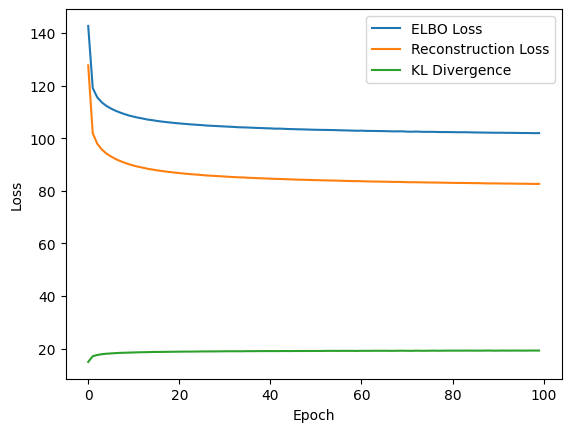

In [ ]:
# Training loop
elbo_losses, recon_losses, kl_losses = [], [], []
for epoch in range(num_epochs):
    model.train()
    total_elbo, total_recon, total_kl = 0, 0, 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_elbo += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
    
    # Log losses
    elbo_losses.append(total_elbo / len(train_loader.dataset))
    recon_losses.append(total_recon / len(train_loader.dataset))
    kl_losses.append(total_kl / len(train_loader.dataset))
    print(f'Epoch {epoch+1}, ELBO: {elbo_losses[-1]:.4f}, Recon: {recon_losses[-1]:.4f}, KL: {kl_losses[-1]:.4f}')

# Plotting losses
plt.plot(elbo_losses, label='ELBO Loss')
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Model Evaluation

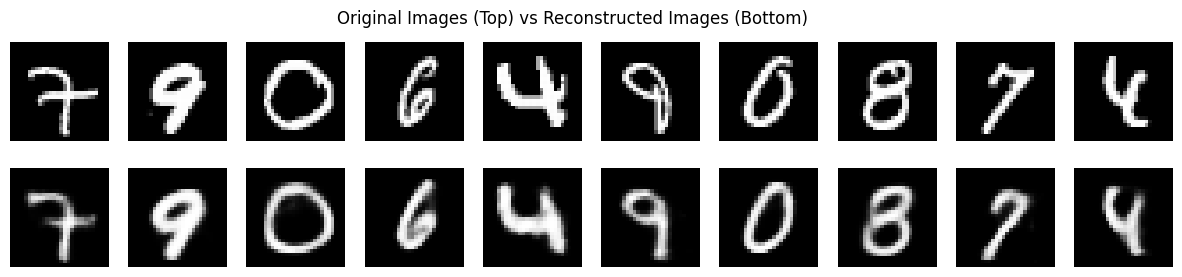

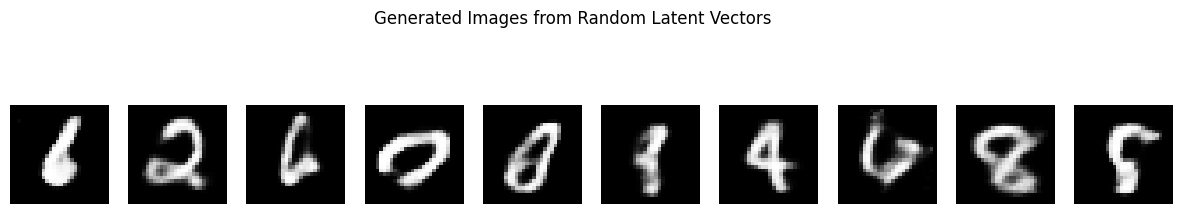

In [ ]:
# load trained VAE model and set it to evaluation mode
model.eval()

# sample a batch of test images
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# get reconstructions
with torch.no_grad():
    reconstructed_images, _, _ = model(test_images)


fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # original images
    axes[0, i].imshow(test_images[i].cpu().view(28, 28), cmap='gray')
    axes[0, i].axis('off')
    # reconstructed images
    axes[1, i].imshow(reconstructed_images[i].cpu().view(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle('Original Images (Top) vs Reconstructed Images (Bottom)')
plt.show()

# generate new images by sampling from latent space
z = torch.randn(10, z_dim).to(device)  # sample random latent vectors
with torch.no_grad():
    generated_images = model.decoder(z)

# plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axes[i].imshow(generated_images[i].cpu().view(28, 28), cmap='gray')
    axes[i].axis('off')
plt.suptitle('Generated Images from Random Latent Vectors')
plt.show()


## Anamoly Detection

cuda


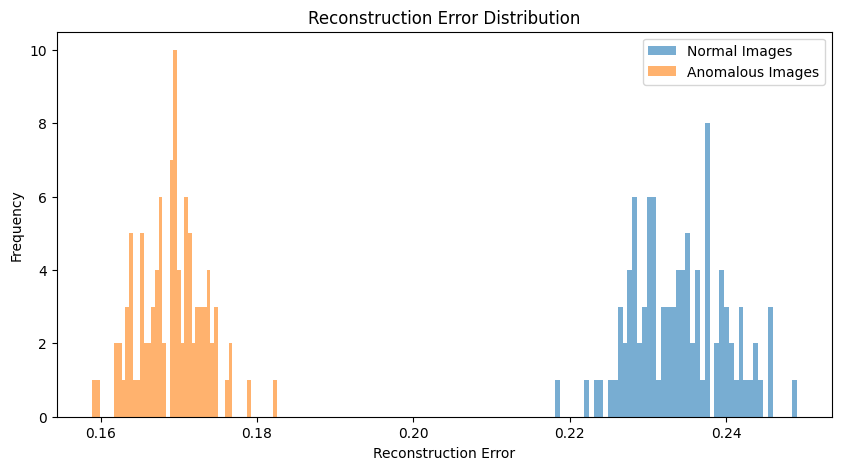

Anomaly detection threshold: 0.2436
Correctly classified normal images: 95/100
Correctly classified anomalies: 0/100


In [ ]:
# add noise to MNIST images for anomaly testing
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn(*images.shape, device=images.device)
    return torch.clip(noisy_images, 0., 1.)

# create noisy test images for anomaly detection
noisy_images = add_noise(test_images)

# evaluate reconstruction errors on normal and noisy images
model.eval()
with torch.no_grad():
    # flatten test images
    test_images_flat = test_images.view(-1, 784)
    reconstructed_images, _, _ = model(test_images_flat)
    
    # calculate reconstruction error on the flattened images
    reconstruction_error_normal = ((test_images_flat - reconstructed_images) ** 2).mean(dim=1).cpu().numpy()
    
    # repeat for noisy images
    noisy_images_flat = noisy_images.view(-1, 784)
    reconstructed_noisy_images, _, _ = model(noisy_images_flat)
    reconstruction_error_anomalous = ((noisy_images_flat - reconstructed_noisy_images) ** 2).mean(dim=1).cpu().numpy()



# plot distribution of reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error_normal, bins=50, alpha=0.6, label='Normal Images')
plt.hist(reconstruction_error_anomalous, bins=50, alpha=0.6, label='Anomalous Images')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

# set threshold based on error distribution
threshold = np.percentile(reconstruction_error_normal, 95)
print(f"Anomaly detection threshold: {threshold:.4f}")

# classify images based on threshold
normal_count = (reconstruction_error_normal < threshold).sum()
anomalous_count = (reconstruction_error_anomalous >= threshold).sum()
print(f"Correctly classified normal images: {normal_count}/{len(reconstruction_error_normal)}")
print(f"Correctly classified anomalies: {anomalous_count}/{len(reconstruction_error_anomalous)}")


## Latent Space Visualization

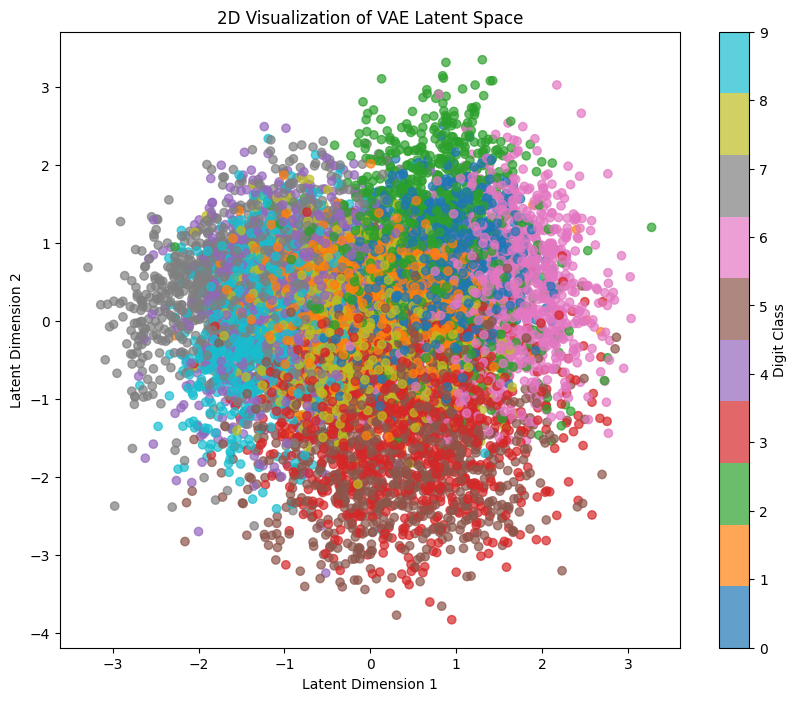

In [ ]:
# extract latent space vectors and labels
model.eval()
latent_vectors = []
labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar = model.encoder(x.view(-1, 784))
        z = model.reparameterize(mu, logvar)
        latent_vectors.append(z.cpu())
        labels.append(y)

# concatenate all latent vectors and labels
latent_vectors = torch.cat(latent_vectors).numpy()
labels = torch.cat(labels).numpy()

# PCA to reduce to 2D if latent dimension is higher than 2
if latent_vectors.shape[1] > 2:
    pca = PCA(n_components=2)
    latent_vectors_2d = pca.fit_transform(latent_vectors)
else:
    latent_vectors_2d = latent_vectors

# plotting the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Digit Class")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Visualization of VAE Latent Space")
plt.show()
